In [1]:
from data import *
from utils.augmentations import SSDAugmentation
import os.path as osp
import sys
import time
import torch
from torch.autograd import Variable
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse
import json
import glob

In [2]:
torch.__version__

'0.4.1'

In [4]:
HOME = os.path.expanduser("~")
droot = osp.join(HOME,"WRS2020/WRS_Dataset")

# DataLoader(Detection用)の実装

In [5]:
WRS2020_CLASSES = (  # always index 0
    'base_plate', 'L-plate_midi', 'L-plate_small',
    'moter', 'ro', 'ro-tall', 'bering-front', 'bering-back',
    'circle', 'pin', "bar", "belt", "ring2-front", "ring2-back", "part", "midi-part")
WRS_ROOT = osp.join(HOME, "WRS2020/WRS_Dataset")

In [6]:
class AnnotationTransform(object):
    """Transforms an annotation into a Tensor of bbox coords and label index
    Initilized with a dictionary lookup of classnames to indexes

    Arguments:
        class_to_ind (dict, optional): dictionary lookup of classnames -> indexes
            (default: alphabetic indexing of VOC's 20 classes)
        keep_difficult (bool, optional): keep difficult instances or not
            (default: False)
        height (int): height
        width (int): width
    """

    def __init__(self, class_to_ind=None, keep_difficult=False):
        
        #self.class_to_ind = class_to_ind or dict(
        #    zip(VISAPP2020_CLASSES, range(len(VISAPP2020_CLASSES))) )
        self.keep_difficult = keep_difficult

    def __call__(self, target, width, height):
        """
        Arguments:
            target (annotation) : json file
        Returns:
            a list containing lists of bounding boxes  [bbox coords, class name]
        """
        res = []
        
        bboxes = target["bbox"]
        class_id = target["class_id"]
        for bbox, cid in zip( bboxes, class_id ):
            bndbox = []
            # クラス名をIDに変換
            label_idx = int(cid)
            # BBoxを取り出して画像サイズで正規化
            bndbox.append( float(bbox[0]) / width )
            bndbox.append( float(bbox[1]) / height )
            bndbox.append( float(bbox[2]) / width )
            bndbox.append( float(bbox[3]) / height )
            bndbox.append(label_idx)
            res += [bndbox]  # [xmin, ymin, xmax, ymax, label_ind]

        return res  # [[xmin, ymin, xmax, ymax, label_ind], ... ]



In [23]:
class WRS2020_Detection(data.Dataset):
    """VISAPP2020 Detection Dataset Object

    input is image, target is annotation

    Arguments:
        root (string): filepath to VISAPP2020(Dataset root) folder.
        image_set (string): imageset to use (eg. 'train', 'val', 'test')
        transform (callable, optional): transformation to perform on the
            input image
        target_transform (callable, optional): transformation to perform on the
            target `annotation`
            (eg: take in caption string, return tensor of word indices)
        dataset_name (string, optional): which dataset to load
            (default: 'VISAPP2020')
    """

    def __init__(self, root,
                 image_set=['train', 'test'],
                 transform=None, target_transform=AnnotationTransform(),
                 dataset_name='WRS_Dataset'):
        self.root = root #WRS_Dataset/
        self.image_set = image_set 
        
        
        self.transform = transform
        self.target_transform = target_transform
        self.name = dataset_name
        self._annopath = osp.join( 'Annotations', 'Far','Image-wise')
        self._imgpath = osp.join( 'Images', 'Far', 'RGB')
        self.ids = list()

        filelist_anno = glob.glob( osp.join(self.root, self._annopath,'*') )
        

        with open( osp.join( root, self._annopath, self.image_set+".txt") ) as f:
            for line in f:
                anno_name = line.strip()
                anno_fullpath = osp.join( root, self._annopath, anno_name )
                img_name = anno_name[:-5]
                img_fullpath = osp.join( root, self._imgpath, img_name )
                self.ids.append( (img_fullpath, anno_fullpath) )
            f.close()
        
                
    def __getitem__(self, index):
        im, gt, h, w = self.pull_item(index)

        return im, gt

    def __len__(self):
        return len(self.ids)
    
    def pull_item(self, index):

        im_name = self.ids[index][0]
        json_name = self.ids[index][1]

        
        if osp.isfile(json_name) == False:
            print( json_name, "was not be found.")
        if osp.isfile(im_name) == False:
            print( im_name, "was not be found.")
        
        anno = open( json_name )
        target = json.load(anno)
        img = cv2.imread( im_name )
        height, width, channels = img.shape
        
        if self.target_transform is not None:
            target = self.target_transform(target, width, height)

        if self.transform is not None:
            target = np.array(target)
            img, boxes, labels = self.transform(img, target[:, :4], target[:, 4])
            # to rgb
            img = img[:, :, (2, 1, 0)]
            # img = img.transpose(2, 0, 1)
            target = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        return torch.from_numpy(img).permute(2, 0, 1), target, height, width
        # return torch.from_numpy(img), target, height, width
    
     
    def pull_image(self, index):
        '''Returns the original image object at index in PIL form

        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.

        Argument:
            index (int): index of img to show
        Return:
            numpy array
        '''
        return cv2.imread(self.ids[index][0], cv2.IMREAD_COLOR) 
    
    def pull_anno(self, index):
        '''Returns the original annotation of image at index

        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.

        Argument:
            index (int): index of img to get annotation of
        Return:
            list:  [img_path, [(label, bbox coords),...]]
                eg: ('../WRS_Dataset/Images/Far/RGB/rgb0.png', [('dog', (96, 13, 438, 332))])
        '''
        anno = open( self.ids[index][1] )
        target = json.load( anno )
        gt = self.target_transform(target, 1, 1)
        return self.ids[index][0], gt
    
    def pull_tensor(self, index):
        '''Returns the original image at an index in tensor form

        Note: not using self.__getitem__(), as any transformations passed in
        could mess up this functionality.

        Argument:
            index (int): index of img to show
        Return:
            tensorized version of img, squeezed
        '''
        return torch.Tensor(self.pull_image(index)).unsqueeze_(0)
    def pull_path(self, index):
        
        return self.ids[index][0], self.ids[index][1]

In [27]:

dataset = WRS2020_Detection( root=droot, image_set = 'train' )

In [28]:
dataset.pull_path(10)

('/home/akizuki/WRS2020/WRS_Dataset/Images/Far/RGB/rgb154.png',
 '/home/akizuki/WRS2020/WRS_Dataset/Annotations/Far/Image-wise/rgb154.png.json')

In [29]:
len(dataset)

800

In [111]:
im = dataset.pull_image(10)

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

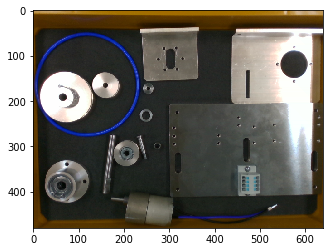

In [113]:
plt.imshow(im)
plt.show()

In [114]:
img, target, height, width = dataset.pull_item(10)

trans


TypeError: __call__() takes exactly 2 arguments (3 given)

In [41]:
id, bboxs = dataset.pull_anno(10)
bboxs

[[132.0, 138.0, 192.0, 197.0, 8],
 [14.0, 136.0, 133.0, 251.0, 4],
 [243.0, 160.0, 268.0, 187.0, 13],
 [235.0, 37.0, 365.0, 156.0, 2],
 [237.0, 219.0, 264.0, 247.0, 15],
 [265.0, 290.0, 283.0, 308.0, 14],
 [228.0, 274.0, 252.0, 329.0, 9],
 [178.0, 286.0, 236.0, 344.0, 6],
 [153.0, 274.0, 183.0, 406.0, 10],
 [25.0, 327.0, 126.0, 426.0, 5],
 [172.0, 399.0, 311.0, 479.0, 3],
 [299.0, 204.0, 639.0, 412.0, 0],
 [435.0, 39.0, 639.0, 203.0, 2]]

# データセットの不正値チェック
全バウンディングボックスをチェックして，画像外のものがないか調べる．
見つかれば，リストアップする．

In [46]:
def write_bbox( im, bbox ):
    flag = True
    im_out = im.copy()
    for b in bbox:
        
        if not 0<= int(b[0]) < 640 or not 0<=int(b[1])<480  or not 0<=int(b[2])<640 or not 0<=int(b[3])<480 :
            print( int(b[0]),int(b[1]), int(b[2]),int(b[3]) )
            im_out = cv2.rectangle(im, (int(b[0]),int(b[1])), (int(b[2]),int(b[3])), (0,0,255), 3 )
            flag = False
        
    return im_out, flag

In [47]:
for i in range( dataset.__len__() ):
    
    id, bboxs = dataset.pull_anno(i)
    im = dataset.pull_image(i)
    im, flag = write_bbox( im, bboxs )
    if flag is False:
        print(i, id)
        im_name, json_name = dataset.pull_path(i)
        print("error img is ", im_name )
        print("error anno is ", json_name )
        cv2.imwrite('debug/im'+id+'.png', im )

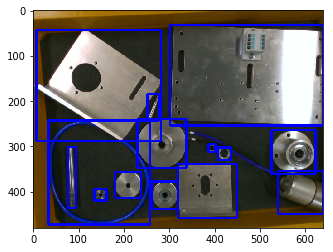

In [51]:
im_out = im.copy()
for b in bboxs:
    im_out = cv2.rectangle(im, (int(b[0]),int(b[1])), (int(b[2]),int(b[3])), (0,0,255), 3 )
plt.imshow( im_out )

In [33]:
bboxs

[[132.0, 138.0, 192.0, 197.0, 8],
 [14.0, 136.0, 133.0, 251.0, 4],
 [243.0, 160.0, 268.0, 187.0, 13],
 [235.0, 37.0, 365.0, 156.0, 2],
 [237.0, 219.0, 264.0, 247.0, 15],
 [265.0, 290.0, 283.0, 308.0, 14],
 [228.0, 274.0, 252.0, 329.0, 9],
 [178.0, 286.0, 236.0, 344.0, 6],
 [153.0, 274.0, 183.0, 406.0, 10],
 [25.0, 327.0, 126.0, 426.0, 5],
 [172.0, 399.0, 311.0, 479.0, 3],
 [299.0, 204.0, 639.0, 412.0, 0],
 [435.0, 39.0, 639.0, 203.0, 2]]

###### dataset.pull_tensor(0)

In [50]:
anno = open('/home/akizuki/VISAPP2020/Dataset/Scene004/DetectionAnnotations/bbox00000.json','r',encoding="Shift-JIS")
json_dict = json.load(anno)
json_dict

{'Annotation': {'filename': 'im_color00000.png',
  'size': [{'width': '640', 'height': '480', 'depth': '3'}],
  'spoon': [{'xmin': '152', 'ymin': '327', 'xmax': '340', 'ymax': '400'}],
  'shovel': [{'xmin': '131', 'ymin': '69', 'xmax': '289', 'ymax': '248'}],
  'spatula': [{'xmin': '430', 'ymin': '129', 'xmax': '505', 'ymax': '342'}],
  'ladle': [{'xmin': '261', 'ymin': '56', 'xmax': '401', 'ymax': '279'}],
  'mug': [{'xmin': '335', 'ymin': '119', 'xmax': '443', 'ymax': '260'}]}}

In [91]:
s

In [108]:
for key in json_dict['Annotation']:
    print(key)
    if key == 'size':
        w = int(json_dict['Annotation'][key][0]["width"])
        h = int(json_dict['Annotation'][key][0]["height"])
    elif key == 'filename':
        continue
    else:
        print(json_dict['Annotation'][key][0]["xmax"])

filename
size
spoon
340
shovel
289
spatula
505
ladle
401
mug
443


In [103]:
int(json_dict['Annotation']['size'][0]["width"])

640

In [2]:
# SSD300 CONFIGS
voc = {
    'num_classes': 21,
    'lr_steps': (80000, 100000, 120000),
    'max_iter': 120000,
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'min_dim': 300,
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes': [30, 60, 111, 162, 213, 264],
    'max_sizes': [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    'variance': [0.1, 0.2],
    'clip': True,
    'name': 'VOC',
}
cfg = voc

In [3]:
dataset = VOCDetection(root="/home/akizuki/Dataset/VOCdevkit/",
                               transform=SSDAugmentation(cfg['min_dim'], MEANS))

In [4]:
im, gt = dataset.__getitem__(0)

In [5]:
im_id, gt = dataset.pull_anno(0)

In [6]:
im_id

'000005'

In [19]:
image_set = "train"
with open( osp.join(droot,'Annotations', 'Far','Image-wise', image_set+".txt") ) as f:
    for line in f:
        print(line.strip())
f.close()

rgb145.png.json
rgb146.png.json
rgb147.png.json
rgb148.png.json
rgb149.png.json
rgb14.png.json
rgb150.png.json
rgb151.png.json
rgb152.png.json
rgb153.png.json
rgb154.png.json
rgb155.png.json
rgb156.png.json
rgb157.png.json
rgb158.png.json
rgb159.png.json
rgb15.png.json
rgb160.png.json
rgb161.png.json
rgb162.png.json
rgb163.png.json
rgb164.png.json
rgb165.png.json
rgb166.png.json
rgb167.png.json
rgb168.png.json
rgb169.png.json
rgb16.png.json
rgb170.png.json
rgb171.png.json
rgb172.png.json
rgb173.png.json
rgb174.png.json
rgb175.png.json
rgb176.png.json
rgb177.png.json
rgb178.png.json
rgb179.png.json
rgb17.png.json
rgb180.png.json
rgb181.png.json
rgb182.png.json
rgb183.png.json
rgb184.png.json
rgb185.png.json
rgb186.png.json
rgb187.png.json
rgb188.png.json
rgb189.png.json
rgb18.png.json
rgb190.png.json
rgb191.png.json
rgb192.png.json
rgb193.png.json
rgb194.png.json
rgb195.png.json
rgb196.png.json
rgb197.png.json
rgb198.png.json
rgb199.png.json
rgb19.png.json
rgb1.png.json
rgb200.png.json


<open file '/home/akizuki/WRS2020/WRS_Dataset/Annotations/Far/Image-wise/train.txt', mode 'r' at 0x7fdd260d7300>